## CV18 - 모델 바꿔보기
### Hourglass 모델

In [1]:
import os

workdir = os.path.join(os.getenv('HOME'), 'aiffel/mpii')
os.chdir(workdir)

In [2]:
%run train.py

Physical devices cannot be modified after being initialized
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',)

Trained batch 600 batch loss 0.480744153 epoch total loss 0.513450325
Epoch 15 train loss 0.5132989287376404
Validated batch 50 batch loss 0.580294251
Epoch 15 val loss 0.5628891587257385
Start epoch 16 with learning rate 0.0007
Start distributed traininng...
Trained batch 200 batch loss 0.498660415 epoch total loss 0.505069256
Trained batch 400 batch loss 0.454469353 epoch total loss 0.503915429
Trained batch 600 batch loss 0.4539617 epoch total loss 0.505025744
Epoch 16 train loss 0.5066301822662354
Validated batch 50 batch loss 0.554489434
Epoch 16 val loss 0.5604418516159058
Start epoch 17 with learning rate 0.0007
Start distributed traininng...
Trained batch 200 batch loss 0.476197034 epoch total loss 0.500201464
Trained batch 400 batch loss 0.318434358 epoch total loss 0.49473232
Trained batch 600 batch loss 0.557304144 epoch total loss 0.500797808
Epoch 17 train loss 0.5003361105918884
Validated batch 50 batch loss 0.514789522
Epoch 17 val loss 0.5562093257904053
Start epoch 18 

### STEP 1: simplebaseline 모델 완성하기

In [ ]:
# SimpleBaseline50.py로 저장
'''
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, ReLU

resnet = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet')


def _make_deconv_layer(num_deconv_layers):
    seq_model = tf.keras.models.Sequential()

    for i in range(num_deconv_layers):
        seq_model.add(Conv2DTranspose(256, kernel_size=(4, 4), strides=(2, 2), padding='same'))
        seq_model.add(BatchNormalization())
        seq_model.add(ReLU())

    return seq_model


upconv = _make_deconv_layer(3)

final_layer = Conv2D(16, kernel_size=(1, 1), padding='same')


def Simplebaseline(input_shape=(256, 256, 3)):
    inputs = Input(shape=input_shape)

    x = resnet(inputs)
    x = upconv(x)
    out = final_layer(x)

    model = tf.keras.Model(inputs, out, name='simple_baseline')
    return model
'''

### STEP 2: simplebaseline 모델로 훈련하기

In [2]:
%run train.py

Physical devices cannot be modified after being initialized
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',)

Trained batch 400 batch loss 6.60661125 epoch total loss 6.34945488
Trained batch 600 batch loss 5.67803192 epoch total loss 6.35229111
Epoch 16 train loss 6.349530220031738
Validated batch 50 batch loss 6.35680199
Epoch 16 val loss 6.264836311340332
Model ./models/model-v0.0.2-epoch-16-loss-6.2648.h5 saved.
Start epoch 17 with learning rate 0.0007
Start distributed traininng...
Trained batch 200 batch loss 6.64207172 epoch total loss 6.33051252
Trained batch 400 batch loss 7.01942 epoch total loss 6.35043716
Trained batch 600 batch loss 6.29041147 epoch total loss 6.34124327
Epoch 17 train loss 6.349025726318359
Validated batch 50 batch loss 6.0067091
Epoch 17 val loss 6.274194240570068
Start epoch 18 with learning rate 0.0007
Start distributed traininng...
Trained batch 200 batch loss 6.44671965 epoch total loss 6.32768631
Trained batch 400 batch loss 6.37672567 epoch total loss 6.35500431
Trained batch 600 batch loss 6.4035821 epoch total loss 6.34123945
Epoch 18 train loss 6.346787

### STEP 3: 두 모델의 비교

In [2]:
import json
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import cv2
import numpy as np
from hourglass104 import StackedHourglassNetwork
from simplebaseline import Simplebaseline
from preprocess import Preprocessor

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

plt.rcParams["figure.figsize"] = (10, 10)

def automatic_gpu_usage() :
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

automatic_gpu_usage()

# 1 Physical GPUs, 1 Logical GPUs

R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],

    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

Physical devices cannot be modified after being initialized


In [8]:
# 모델과 학습된 weight 불러오기

SHG_model = StackedHourglassNetwork()
SHG_model.load_weights('./models/model-v0.0.1-epoch-13-loss-0.5548.h5')

SB_model = Simplebaseline()
SB_model.load_weights('./models/model-v0.0.2-epoch-16-loss-6.2648.h5')

In [4]:
def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (4096, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()

def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)

    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        # since we've padded the heatmap, the max keypoint should increment by 1
        max_y = keypoint[1]+1
        max_x = keypoint[0]+1
        # the patch is the 3x3 grid around the max keypoint location
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i]
        # assign 0 to max location
        patch[1][1] = 0
        # and the next largest value is the largest neigbour we are looking for
        index = np.argmax(patch)
        # find out the location of it relative to center
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4
        # we can then add original max keypoint location with this offset
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
    # we do need to clip the value to make sure there's no keypoint out of border, just in case.
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    # normalize the points so that we can scale back easily
    normalized_keypoints = adjusted_keypoints / 64
    return normalized_keypoints

def predict(image_path, model=SHG_model):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False)
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image, kp

In [5]:
def draw_keypoints_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()
        
def draw_skeleton_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    # draw skeleton
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()

#### Pose Estimation 결과 시각화

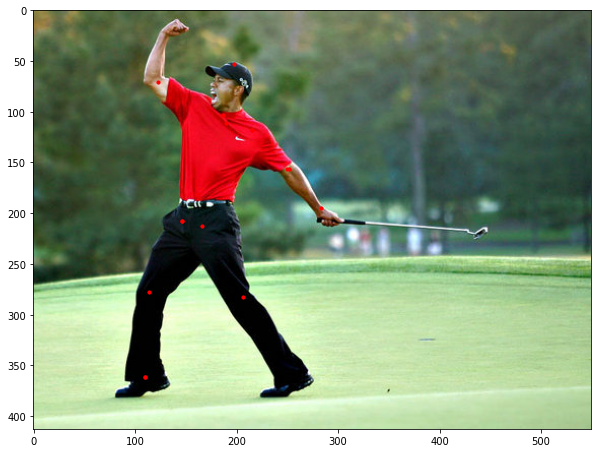

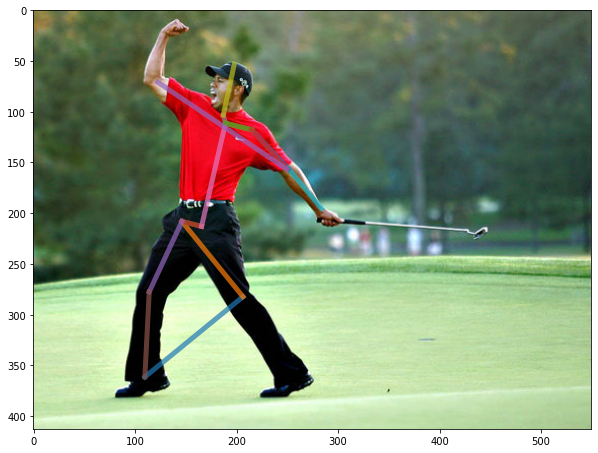

In [7]:
image, keypoints = predict('./test_image.jpg')
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

In [9]:
image, keypoints = predict('./test_image.jpg', SB_model)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

InvalidArgumentError: Can not squeeze dim[0], expected a dimension of 1, got 64 [Op:Squeeze]